# Jpeg algorithm

**Groupe 30**: Tony Heng / Gabriel Rayzal / Nathan Cabasso / Ferdinand Mom

In [13]:
# Explained what is JPEG etc ...

# Table of Contents

- I/ Theory
    - 1) Compression
    - 2) Decompression
    - 3) Metrics
- II/ Practical
    - 1) Example Compression & Decompression
    - 2) Different quality of compression

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

from src.compression import *
from src.decompression import *
from src.utils import *

---

# I/ Theory

# <ins>1) Compression </ins>

Whole compression pipeline

![](https://cdn.discordapp.com/attachments/844292513665515531/859104978538856448/unknown.png)

## A) Block splitting

First step is to divide input image into non-overlapping 8 × 8 macro-blocks.
![](https://cdn.discordapp.com/attachments/844292513665515531/859064441525370900/unknown.png)
If the dimensions are not divisible in integer numbers of blocks, the image can be padded:

- zero padding: #TODO
- replicating border: #TODO

A naive approach could be to pad only a side of the image (bottom-left). The downside of this approach is that we can find ourselves with macro-blocks full of zeros. Thus, we decided to implement our padding in a such way that the image is always center in the middle.

## B) DCT

The second step is to perform a DCT (Discret Cosine Transformation) on each macro-block. To understand the need of DCT, we need to first understand what is an image. An image is the superposition of:

- Low frequencies: overall structure of image.
- High frequencies: Details (edges and noises)

An image is originally represented in its spatial representation which means the image is decomposed in a set of basis image.

![](https://cdn.discordapp.com/attachments/844292513665515531/859090327977721866/unknown.png)

The problem is then the following: How do we discard the useless part of high frequency (noises) without removing important information ?

To do so, we perform a frequency analysis of the image. However, the way the image is initially represented (in spatial representation) is not suited to carry out a frequency analysis. Indeed, high frequencies are disseminated everywhere in the image so it is hard to tell whether a quick variation in terms of pixel is due to an edge (important) or noise (to be discarded).

That is why we need to change the representation of our image which is done by performing transformations on our image in order to represent it into a new basis. More precisely, the transformation will enable to represent our image into a new basis. Here are some transformations:

- Walsh-Hadamard
- Discret Fourier Transform (DFT)
- Discret Cosine Transform (DCT)

JPEG uses DCT which succeed in compacting most of the image energy into as few coefficients as possible compare to Waslh-Hadamard and does not require to store complex number (real and imaginary parts) like DFT which requires double the memory for storage.

Each 8x8 macro-block will then be multiply with the following DCT kernel matrix:

![](https://cdn.discordapp.com/attachments/844292513665515531/859082211910221824/unknown.png)

The result of the DCT is also an 8 by 8 block where the first coefficient at the top left corner represents the DC coefficient. Remaining coefficients are called AC coefficients. The advantage of the DCT is its tendency to aggregate most of the signal in top left corner of the result. Note that the higher the coefficient, the more information it contains, useful to properly reconstruct the image. Thus, we can gain in storage by removing smaller coefficients which is the goal of next step.

In [15]:
def test_dct():
    # Taken from wikipedia: https://en.wikipedia.org/wiki/JPEG#Encoding
    block = np.array([
        [52, 55, 61, 66, 70, 61, 64, 73],
        [63, 59, 55, 90, 109, 85, 69, 72],
        [62, 59, 68, 113, 144, 104, 66, 73],
        [63, 58, 71, 122, 154, 106, 70, 69],
        [67, 61, 68, 104, 126, 88, 68, 70],
        [79, 65, 60, 70, 77, 68, 58, 75],
        [85, 71, 64, 59, 55, 61, 65, 83],
        [87,  79, 69, 68, 65, 76, 78, 94]]
    )

    expected = np.array([
        [-415.38, -30.19, -61.20, 27.24, 56.12, -20.10, -2.39, 0.46],
        [4.47, -21.86, -60.76, 10.25, 13.15, -7.09, -8.54, 4.88],
        [-46.83, 7.37, 77.13, -24.56, -28.91, 9.93, 5.42, -5.65],
        [-48.53, 12.07, 34.10, -14.76, -10.24, 6.30, 1.83, 1.95],
        [12.12, -6.55, -13.20, -3.95, -1.87, 1.75, -2.79, 3.14],
        [-7.73, 2.91, 2.38, -5.94, -2.38, 0.94, 4.30, 1.85],
        [-1.03, 0.18, 0.42, -2.42, -0.88, -3.02, 4.12, -0.66],
        [-0.17, 0.14, -1.07, -4.19, -1.17, -0.10, 0.50, 1.68]]
    )

    result = dct(block)
    assert np.allclose(result, expected, atol=1e-2, rtol=0.) == True
    print("[test_dct]: OK")

test_dct()

[test_dct]: OK


## C) Quantization

The third step is quantization which looks for a way to maximize the number of 0 coefficients. This is done through the use of quantization matrix which were found empirically.

First quantization matrix is for RGB image while second one is for YUV image (only to be applied to UV channels): 

![](https://cdn.discordapp.com/attachments/844292513665515531/859100308390805534/quantification_Qq.png)
![](https://cdn.discordapp.com/attachments/844292513665515531/859100870369214534/quantification_Quv.png)

The formula is the following:

$$round(\frac{DCT(block - 128)}{Q})$$

- Before applying DCT, we must remove 128 to each 8x8 macro-block because statiscally, it was found that the mean value of an 8x8 macro-block is close to 128. Thus, $DCT(block - 128)$ wille result in more value close to 0.
- After dividing by the quantization matrix, we round to the nearest integer. This is the reason why JPEG is a lossy algorithm. It will not be possible to recover the same value during decompression.

One can also change the quality of compression using a quality factor $q \in [1, 100]$ and the following algorithm:

![](https://cdn.discordapp.com/attachments/844292513665515531/859104454381142046/unknown.png)

The higher $q$ is, the more similar the compressed image will be compared to the original image.

In [16]:
def test_quantization():
    # Taken from wikipedia: https://en.wikipedia.org/wiki/JPEG#Encoding
    dct_block = np.array([
        [-415.38, -30.19, -61.20, 27.24, 56.12, -20.10, -2.39, 0.46],
        [4.47, -21.86, -60.76, 10.25, 13.15, -7.09, -8.54, 4.88],
        [-46.83, 7.37, 77.13, -24.56, -28.91, 9.93, 5.42, -5.65],
        [-48.53, 12.07, 34.10, -14.76, -10.24, 6.30, 1.83, 1.95],
        [12.12, -6.55, -13.20, -3.95, -1.87, 1.75, -2.79, 3.14],
        [-7.73, 2.91, 2.38, -5.94, -2.38, 0.94, 4.30, 1.85],
        [-1.03, 0.18, 0.42, -2.42, -0.88, -3.02, 4.12, -0.66],
        [-0.17, 0.14, -1.07, -4.19, -1.17, -0.10, 0.50, 1.68]]
    )

    Q_MAT = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72,  92, 95, 98, 112, 100, 103, 99]]
    )

    expected = np.array([
        [-26, -3, -6, 2, 2, -1, 0, 0],
        [0, -2, -4, 1, 1, 0, 0, 0],
        [-3, 1, 5, -1, -1, 0, 0, 0],
        [-3, 1, 2, -1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]
    )

    result = quantization(dct_block, Q_MAT)
    assert np.allclose(result, expected) == True
    assert result.dtype == expected.dtype
    print("[test_quantization]: OK")

test_quantization()

[test_quantization]: OK


## D) Zigzag + Huffman

### Zigzag

The goal of this step is to represent our 8x8 macro-block with only the essential coefficients. Indeed, after quantization, a lot of coefficients on the bottom corner of our macro-block are set to 0 while most of the important coefficients are on the top left corner.

![](https://cdn.discordapp.com/attachments/844292513665515531/859105773091291146/unknown.png)

In [17]:
def test_zigzag():
    # Taken from wikipedia: https://en.wikipedia.org/wiki/JPEG#Encoding
    quantized_block = np.array([
        [-26, -3, -6, 2, 2, -1, 0, 0],
        [0, -2, -4, 1, 1, 0, 0, 0],
        [-3, 1, 5, -1, -1, 0, 0, 0],
        [-3, 1, 2, -1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]
    )

    expected = np.array(
        [-26,
        -3, 0,
        -3, -2, -6,
        2, -4, 1, -3,
        1, 1, 5, 1, 2,
        -1, 1, -1, 2, 0, 0,
        0, 0, 0, -1, -1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0,
        0, 0, 0, 0,
        0, 0, 0,
        0, 0,
        0]
    )
    result = zigzag(quantized_block)
    assert np.allclose(result, np.trim_zeros(expected, trim='b')) == True
    print("[test_zigzag]: OK")
    
test_zigzag()

[test_zigzag]: OK


### Huffman

We know need to encode coefficients in the zigzag ordering using JPEG predefined Huffman table for DC/AC coefficients. We used tables from "Digital Image Processing" by Rafael C. Gonzalez & Richard E. Woods page 934.

Let's denote:

- **A**: JPEG coefficients coding categories table
- **B**: JPEG DC coefficients table
- **C**: JPEG AC coefficients table

**<ins>To encode DC coefficient<ins>:** $DC = -26$
- Check in **A** in which category <a style="color:green">CAT</a> $-26$ belongs to: (category 5).
    - This means that -26 needs 5 bits to be represented in binary.
    - Retrieve <a style="color:red">binary representation</a> of number with <a style="color:green">CAT</a> in **A** (<a style="color:red">00101</a>)
    ![](https://cdn.discordapp.com/attachments/844292513665515531/859111745871413278/unknown.png)
- Retrieve codeword in **B** using <a style="color:green">CAT</a> $\to$ codeword = <mark> <a style="color:green">110</a></mark>
    - Conclusion: $DC =$ <mark><a style="color:green">110</a></mark> <a style="color:red">00101</a>
    
**<ins>To encode AC coefficients<ins>:** $AC = -3$ (The second $-3$ on above zigzag ordering)
- Check in **A** in which category <a style="color:green">CAT</a> $-3$ belongs to: (category 2)
  - This means that -3 needs 2 bits to be represented in binary.
    - Retrieve <a style="color:red">binary representation</a> of number with <a style="color:green">CAT</a> in **B** (<a style="color:red">00</a>)
    ![](https://cdn.discordapp.com/attachments/844292513665515531/859113073365614602/unknown.png)
- Compute <a style="color:purple">RUN</a> which correspond to number of 0s precedding AC coeff (<a style="color:purple">RUN=1</a>)
- Retrieve codeword in **C** using <mark><a style="color:purple">RUN</a>/<a style="color:green">CAT</a> = <a style="color:purple">1</a>/<a style="color:green">2</a></mark> $\to$ codeword = <mark>111001</mark>
- Conclusion: $AC = $ <mark>111001</mark><a style="color:red">00</a>

In [18]:
def test_huffman():
    largest_range = list(itertools.product(['0', '1'], repeat=15))

    # Regular Huffman.
    zigzag_order = np.array([-26, -3, 0, -3, -2, -6, 2, -4, 1, -3, 1, 1, 5, 1, 2, -1, 1, -1, 2, 0, 0, 0, 0, 0, -1, -1, 0])
    expected = np.array(["11000101","0100","11100100","0101","100001","0110","100011","001","0100","001","001","100101","001","0110","000","001","000","0110","11110100","000","1010"])

    result = huffman(zigzag_order, largest_range)
    assert len(result) == len(expected)
        
    for res, exp in zip(result, expected):
        assert res == exp
    
    # Huffman with 27 zeros before AC coeff.
    zigzag_order = np.array([-26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1])
    expected = np.array(["11000101", "1111111101110", "11111110101", "1010"])

    result = huffman(zigzag_order, largest_range)
    assert len(result) == len(expected)
    
    for res, exp in zip(result, expected):
        assert res == exp
    
    print("[test_huffman]: OK")

test_huffman()

[test_huffman]: OK


---

# <ins>2) Decompresion </ins>

JPEG decompression process is the exact inverse of the compression scheme.

![](https://cdn.discordapp.com/attachments/844292513665515531/859105375265226782/unknown.png)

## A) Huffman$^{-1}$ + Zigzag$^{-1}$

### Huffman$^{-1}$

From the bitstream, we have to recover the 8x8 macro-block in zigzag order. To do so, we use a "sliding window" approach where we check if the codeword formed by the sliding window belongs to the table or not. A full 8x8 macro-block is found when reaching the EOB = "1010" (End Of Block) symbol.

![](https://cdn.discordapp.com/attachments/844292513665515531/859134555893399614/unknown.png)

In [19]:
def test_huffman_inv():
    bitstream = "1100010101001110010001011000010110100011001010000100110010100101100000010000110111101000001010"
    largest_range = list(itertools.product(['0', '1'], repeat=15))
    expected = [-26, -3, 0, -3, -2, -6, 2, -4, 1, -3, 1, 1, 5, 1, 2, -1, 1, -1, 2, 0, 0, 0, 0, 0, -1, -1]

    result = next(iter(huffman_inv(bitstream, largest_range)))
    assert len(result) == len(expected)
    assert np.allclose(result, expected) == True
    
    print("[test_huffman_inv]: OK")

test_huffman_inv()

[test_huffman_inv]: OK


### Zigzag$^{-1}$

We recreate the 8x8 matrix by re-placing values of the zigzag order.

![](https://cdn.discordapp.com/attachments/844292513665515531/859135707671035944/unknown.png)

In [20]:
def test_zigzag_inv():
    #  Top left corner matrix.
    zigzag_order = [-26, -3, 0, -3, -2, -6, 2, -4, 1, -3, 1, 1, 5, 1, 2, -1, 1, -1, 2, 0, 0, 0, 0, 0, -1, -1]
    expected = np.array([
        [-26, -3, -6,  2,  2, -1,  0,  0],
        [  0, -2, -4,  1,  1,  0,  0,  0],
        [ -3,  1,  5, -1, -1,  0,  0,  0],
        [ -3,  1,  2, -1,  0,  0,  0,  0],
        [  1,  0,  0,  0,  0,  0,  0,  0],
        [  0,  0,  0,  0,  0,  0,  0,  0],
        [  0,  0,  0,  0,  0,  0,  0,  0],
        [  0,  0,  0,  0,  0,  0,  0,  0]]
    )

    result = zigzag_inv(zigzag_order)
    assert np.allclose(result, expected) == True
    
    # Whole matrix.
    zigzag_order = [-42, -1, -7, -6, 0, -38, 3, 4, -1, -3, -9, -2, 7, 0, 7, -4, 2, 0, 2, 1, 7, -3, 1, 5, 2, -2, 0, 0, 4, -1, 2, -1, -1, -2, 0, 1, 0, 1, -1, -1, -1, 1, 1, -3, 0, 0, -1, 0, -1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, -1, 0, -1, 0, -1]
    expected = np.array([
        [-42, -1, -38,  3,  7,  -4,  0,  4],
        [ -7,  0,   4,  0,  2,   0, -1,  1],
        [ -6, -1,   7,  0,  -2,  2,  1, -3],
        [ -3, -2,   2,  2,  -1, -1,  0,  0],
        [ -9,  1,   5, -1,  -1,  0,  0,  0],
        [  7,  1,  -2, -1,  -1,  1,  1,  0],
        [ -3,  0,   1,  0,   1,  0, -1, -1],
        [  1,  0,  -1,  0,   1,  1,  0, -1]]
    )
        
    result = zigzag_inv(zigzag_order)
    assert np.allclose(result, expected) == True

    print("[test_zigzag_inv]: OK")

test_zigzag_inv()

[test_zigzag_inv]: OK


## B) Reverse quantization

An element-wise multiplication (Hadamard product) is performed to retrieve the matrix before quantization. Note that the retrieved matrix is different from the one in compression since we performed a rounding operation.

![](https://cdn.discordapp.com/attachments/844292513665515531/859135529287286834/unknown.png)

In [21]:
def test_quantization_inv():
    q_block = np.array([
        [-26, -3, -6, 2, 2, -1, 0, 0],
        [0, -2, -4, 1, 1, 0, 0, 0],
        [-3, 1, 5, -1, -1, 0, 0, 0],
        [-3, 1, 2, -1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0]]
    )

    expected = np.array([
        [-416,  -33,  -60,   32,   48,  -40,    0,    0],
        [   0,  -24,  -56,   19,   26,    0,    0,    0],
        [ -42,   13,   80,  -24,  -40,    0,    0,    0],
        [ -42,   17,   44,  -29,    0,    0,    0,    0],
        [  18,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0]
    ])


    result = quantization_inv(q_block, Q_MAT)
    assert np.allclose(result, expected) == True
    print("[test_quantization_inv]: OK")

test_quantization_inv()

[test_quantization_inv]: OK


## C) DCT$^{-1}$

The reverse DCT is performed to retrieve the initial 8x8 macro-block. We used the following formula:

$$block = DCT^{-1}(\tilde{J}_{Bi^*}) + 128$$

In [22]:
def test_dct_inv():
    dct_block = np.array([
        [-416,  -33,  -60,   32,   48,  -40,    0,    0],
        [   0,  -24,  -56,   19,   26,    0,    0,    0],
        [ -42,   13,   80,  -24,  -40,    0,    0,    0],
        [ -42,   17,   44,  -29,    0,    0,    0,    0],
        [  18,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0,    0]
    ])

    expected = np.array([
        [62, 65, 57, 60, 72, 63, 60, 82],
        [57, 55, 56, 82, 108, 87, 62, 71],
        [58, 50, 60, 111, 148, 114, 67, 65],
        [65, 55, 66, 120, 155, 114, 68, 70],
        [70, 63, 67, 101, 122, 88, 60, 78],
        [71, 71, 64, 70, 80, 62, 56, 81],
        [75, 82, 67, 54, 63, 65, 66, 83],
        [81, 94, 75, 54, 68, 81, 81, 87]
    ])
        
    result = dct_inv(dct_block)
    assert np.allclose(result, expected) == True
    print("[test_dct_inv]: OK")

test_dct_inv()

[test_dct_inv]: OK


## D) Block combination

We are only left with combining all retrieved 8x8 macro-block to form the original image.
![](https://cdn.discordapp.com/attachments/844292513665515531/859136855672750130/unknown.png)

# 3) Metrics

It is possible to quantitatively assess the compression / decompression error $\epsilon = I − I'$ with
numerical measures:

- Root mean square error: $\text{RMSE}(\epsilon) = \sqrt{\frac{1}{MN} \sum_{m=0}^{M-1} \sum_{n=0}^{N-1} \epsilon(m,n)^2 }$
- Signal-to-noise ratio: $\text{SNR}(\epsilon) = 10 * log(\frac{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} I(m,n)^2}{\sum_{m=0}^{M-1} \sum_{n=0}^{N-1} \epsilon(m,n)^2})$

In [23]:
def test_rmse():
    # Same_image
    input_img = plt.imread("./img/nyancat-patrick.png")[..., :3] * 255
    out_img = input_img
    result = rmse(input_img, out_img)
    assert result == 0
    
    # Different_image
    input_img = plt.imread("./img/nyancat-patrick.png")[..., :3] * 255
    out_img = np.random.uniform(0., 1., (input_img.shape)) * 255
    result = rmse(input_img, out_img)
    assert result > 90
    
    print("[test_rmse]: OK")
    
test_rmse()

[test_rmse]: OK


In [31]:
def test_snr():
    # Same_image
    input_img = plt.imread("./img/nyancat-patrick.png")[..., :3] * 255
    out_img = input_img
    result = snr(input_img, out_img)
    assert result > 100
    
    # Different_image
    input_img = plt.imread("./img/nyancat-patrick.png")[..., :3] * 255
    out_img = np.random.uniform(0., 1., (input_img.shape)) * 255
    result = snr(input_img, out_img)
    
    assert int(result) < 15
    
    print("[test_snr]: OK")
    
test_snr()

[test_snr]: OK


---

# II/ Pratical

# 1) Example Compression & Decompression

In [86]:
def demo_compression_decompression(img_path, q):
    input_img = plt.imread(img_path)[..., :3] * 255

    t0_compression = time.time()
    bitstream, info_padding = compression(input_img, q=q, channel_mode="rgb")
    t1_compression = time.time()
    
    t0_decompression = time.time()
    out_img = decompression(bitstream, info_padding, q=q)
    t1_decompression = time.time()
    
    # Plot
    fig = plt.figure(figsize=(20,20))
    
    fig.add_subplot(1,3,1)
    plt.title("Input image")
    plt.imshow(input_img / 255)
    
    fig.add_subplot(1,3,2)
    plt.title("Output image (Compression + decompression)")
    plt.imshow(out_img / 255)
    
    fig.add_subplot(1,3,3)
    plt.title("Error")
    error = np.abs(input_img - out_img)/2 + 125
    plt.imshow(error / 255)

    
    print(f"Quality factor q = {q}")
    print(f"RMSE = {rmse(input_img, out_img)}")
    print(f"SNR = {snr(input_img, out_img)} dB")
    print(f"Compression  time = {t1_compression - t0_compression} s")
    print(f"Decompression time = {t1_decompression - t0_decompression} s")
    print(f"Compression + Decompression time = {t1_decompression - t0_compression} s")

Quality factor q = 50
RMSE = 5.742078338121573
SNR = 60.704534558105834 dB
Compression  time = 4.679030656814575 s
Decompression time = 2.285203218460083 s
Compression + Decompression time = 6.964234352111816 s


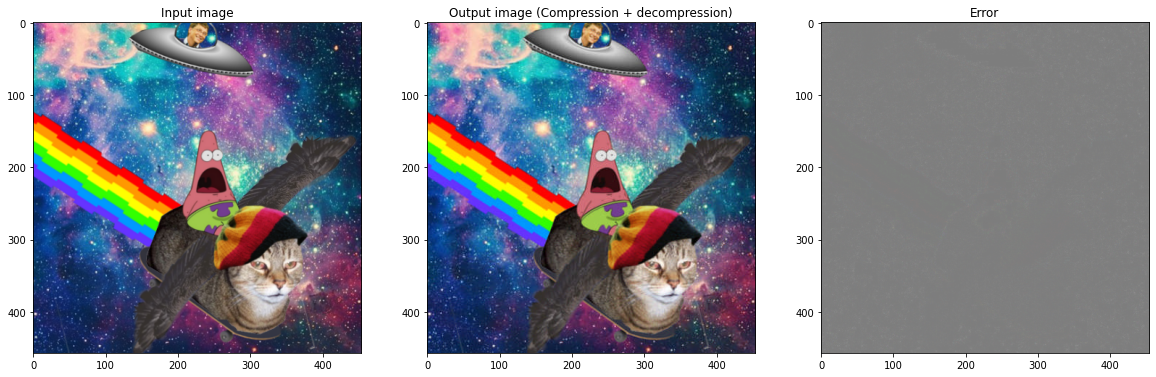

In [87]:
demo_compression_decompression("img/patrick-color.png", q=50)

# 2) Different quality of compression

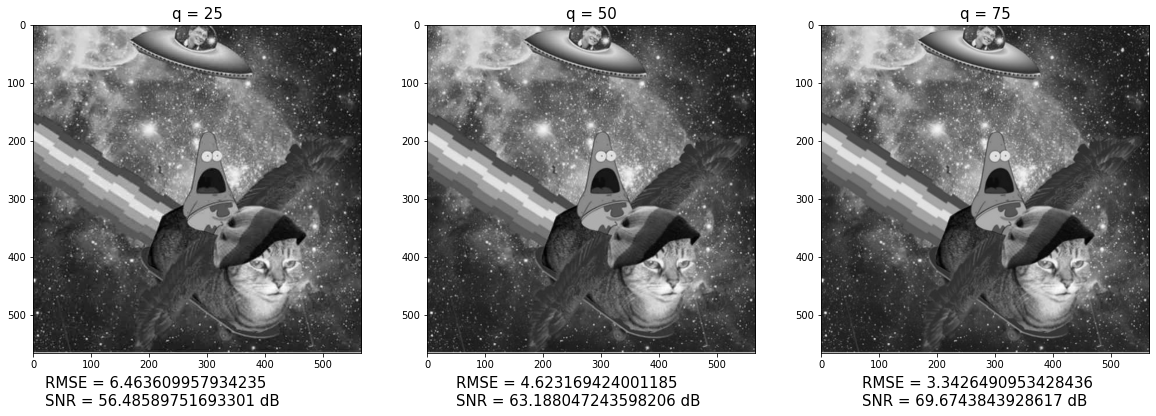

In [60]:
def demo_quality_compression(img_path):
    input_img = plt.imread(img_path)[..., :3] * 255
    
    RMSE, SNR, out_images = [], [], []

    for q in [25, 50, 75]:
        bitstream, info_padding = compression(input_img, q=q, channel_mode="rgb")
        out_img = decompression(bitstream, info_padding, q=q)
        
        RMSE.append(rmse(input_img, out_img))
        SNR.append(snr(input_img, out_img))
        out_images.append(out_img)
            
    # Plot
    fig = plt.figure(figsize=(20,20))
    
    fig.add_subplot(1,3,1)
    plt.title("q = 25", fontsize=15)
    plt.imshow(out_images[0] / 255)
    plt.text(20, out_images[0].shape[0] + 60, f"RMSE = {RMSE[0]}", fontsize=15)
    plt.text(20, out_images[0].shape[0] + 90, f"SNR = {SNR[0]} dB", fontsize=15)
    
    fig.add_subplot(1,3,2)
    plt.title("q = 50", fontsize=15)
    plt.imshow(out_images[1] / 255)
    plt.text(50, out_images[1].shape[0] + 60, f"RMSE = {RMSE[1]}", fontsize=15)
    plt.text(50, out_images[1].shape[0] + 90, f"SNR = {SNR[1]} dB", fontsize=15)
    
    fig.add_subplot(1,3,3)
    plt.title("q = 75", fontsize=15)
    plt.imshow(out_images[2] / 255)
    plt.text(70, out_images[2].shape[0] + 60, f"RMSE = {RMSE[2]}", fontsize=15)
    plt.text(70, out_images[2].shape[0] + 90, f"SNR = {SNR[2]} dB", fontsize=15)

demo_quality_compression("img/nyancat-patrick.png")